# How to conduct FE simulations with JFEM?

*See "field" and "element" documents in advance.*

## 1. Simple seepage problem

### Define condition of simulation

In [1]:
using JFEM

elt1 = Quad4([1,2,3,4])
elt2 = Quad4([2,5,6,3])
elt1["geometry"] = Field([[0.0,0.0], [1.0,0.0], [1.0,1.0], [0.0,1.0]])
elt2["geometry"] = Field([[1.0,0.0], [2.0,0.0], [2.0,1.0], [1.0,1.0]])
elements = [elt1, elt2]

for elt in elements
    elt["water head"] = Field([0.0, 0.0, 0.0, 0.0]) # set initial water head
    elt["water conductivity"] = ConstantField(1e-2)
end

FE mesh:

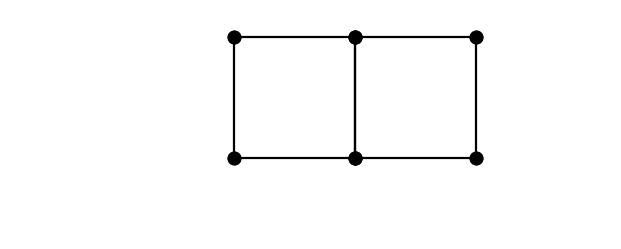

In [2]:
using PyPlot

function plot_mesh(elements; time=:end, color="0")
    axis("off")
    axis("equal")
    for elt in elements
        geometry = elt["geometry"][time]
        for i in 1:length(geometry)-1
            pt1 = geometry[i]
            pt2 = geometry[i+1]
            plot([pt1[1],pt2[1]], [pt1[2],pt2[2]], color=color, linewidth=0.4, marker="o", markersize=2, clip_on=false)
        end
        pt1 = geometry[1]
        pt2 = geometry[end]
        plot([pt1[1],pt2[1]], [pt1[2],pt2[2]], color=color, linewidth=0.4, marker="o", markersize=2, clip_on=false)
    end
    tight_layout()
end
figure(figsize=(2,1))
plot_mesh(elements)

### How to create an element matrix?

In [3]:
function create_matrix(element)
    num_nodes = length(element)
    K = zeros(num_nodes, num_nodes)
    for gp in get_gauss_points(element)
        w = gp.weight * element(Val{:detJ}, gp)
        B = element(Val{:GRAD}, gp)
        k = element("water conductivity", gp)
        K += -w * B' * k * B
    end
    return K
end
create_matrix(elt1)

4×4 Array{Float64,2}:
 -0.00666667   0.00166667   0.00333333   0.00166667
  0.00166667  -0.00666667   0.00166667   0.00333333
  0.00333333   0.00166667  -0.00666667   0.00166667
  0.00166667   0.00333333   0.00166667  -0.00666667

### How to create a global matrix?

In [4]:
num_nodes = 6
global_matrix = zeros(num_nodes, num_nodes)
for elt in elements
    dofs = get_dofs(elt, 1)
    global_matrix[dofs,dofs] += create_matrix(elt)
end

### What is the `get_dofs` function?

Consider global unknown vector as
$$
[u_{1x},u_{1y},u_{2x},u_{2y},u_{3x},u_{3y},u_{4x},u_{4y},u_{5x},u_{5y},u_{6x},u_{6y}]^T
$$
To get vector indices of specific nodes,

In [5]:
@show get_dofs([2,5,6,3], 2)    # get_dofs(node_numbers, variable_dimension)
@show get_dofs([2,5,6,3], 2, 1) # for x
@show get_dofs([2,5,6,3], 2, 2) # for y

# for seepage problem
@show get_dofs([2,5,6,3], 1)
@show get_dofs(elt2, 1) # get_dofs(get_connectivity(elt2), 1)

get_dofs([2,5,6,3],2) = [3,4,9,10,11,12,5,6]
get_dofs([2,5,6,3],2,1) = [3,9,11,5]
get_dofs([2,5,6,3],2,2) = [4,10,12,6]
get_dofs([2,5,6,3],1) = [2,5,6,3]
get_dofs(elt2,1) = [2,5,6,3]


4-element Array{Int64,1}:
 2
 5
 6
 3

### How to solve a problem with boundary conditons?

Create boundary elements

In [6]:
left_boundary = Bar2([4,1])
right_boundary = Bar2([5,6])

JFEM.Element{1,2}([5,6],JFEM.GaussPoint[[-0.57735],[0.57735]],JFEM.ShapeFunction(JFEM.N,JFEM.∇N),Dict{String,JFEM.Field}())

FE mesh:

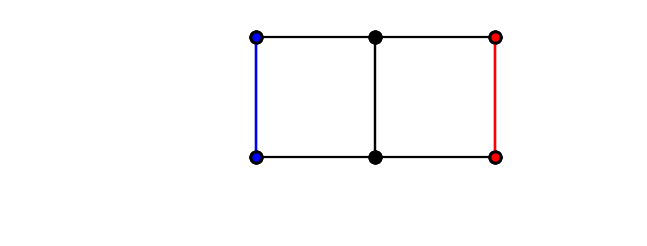

In [7]:
left_boundary["geometry"]  = Field([[0.0,1.0], [0.0,0.0]])
right_boundary["geometry"] = Field([[2.0,0.0], [2.0,1.0]])

figure(figsize=(2,1))
plot_mesh(elements)
plot_mesh(left_boundary, color="blue")
plot_mesh(right_boundary, color="red")

Solve problem

In [8]:
b = zeros(num_nodes) # right hand side vector
x = zeros(num_nodes) # left hand side vector

left_boundary["water flow rate"] = Field(-[0.01, 0.01]) # set neumann boundary condition
right_boundary["water head"] = Field([0.0, 0.0])        # set dirichlet boundary condition

# set neumann boundary condition into right hand side vector b
b[get_dofs(left_boundary, 1)] = left_boundary["water flow rate"][end]

# use Gaussian elimination method
ddofs = get_dofs(right_boundary, 1) # dirichlet dofs
x[ddofs] = right_boundary["water head"][end]
for i in ddofs
    b -= x[i] * global_matrix[:,i]
end

fdofs = [1,2,3,4] # free dofs
x[fdofs] = global_matrix[fdofs, fdofs] \ b[fdofs]
x

6-element Array{Float64,1}:
 4.0
 2.0
 2.0
 4.0
 0.0
 0.0

Update element fields

In [9]:
for elt in elements
    dofs = get_dofs(elt, 1)
    h = x[dofs]
    push!(elt["water head"], h)
end

Show results

In [10]:
for elt in elements
    mid = [0.0,0.0] # center of element
    k = elt("water conductivity", mid)
    @show ∇h = elt("water head", Val{:GRAD}, mid)
    @show v = -k * ∇h
end

∇h = elt("water head",Val{:GRAD},mid) = [-2.0; 8.88178e-16]
v = -k * ∇h = [0.02; -8.88178e-18]
∇h = elt("water head",Val{:GRAD},mid) = [-2.0; 1.11022e-16]
v = -k * ∇h = [0.02; -1.11022e-18]


## 2. Simplify codes

### Assembly, Dirichlet and Neumann

`In[4]` and `In[8]` can be simplified as

In [11]:
assembly, dirichlet, neumann = Assembly(), Dirichlet(), Neumann()

# add element matrix to assembly
for elt in elements
    dofs = get_dofs(elt, 1)
    add!(assembly, dofs, dofs, create_matrix(elt))
end

# set boundary conditions
add!(neumann, get_dofs(left_boundary,1), -[0.01,0.01]) # add!(neumann, dofs, val)
dirichlet[get_dofs(right_boundary,1)] = 0.0            # dirichlet[dofs]

# solve problem
x = solve(assembly, dirichlet, neumann)

6-element Array{Float64,1}:
 4.0
 2.0
 2.0
 4.0
 0.0
 0.0

### Seepage equation

If you use builtin equation `Seepage`, `In[3]` and `In[4]` can be simplified as

In [12]:
equation = Seepage("water head") # set unknown field name
assembly = Assembly()

# assemble global matrix by using Seepage equation
for elt in elements
    dofs = get_dofs(elt, 1)
    assemble!(assembly, dofs, equation, elt)
end

INFO: water head: unit -> length, potential -> total


### Domain
If you create `Domain` type with `elements` and `Equation`, `In[12]` will be

In [13]:
domain = Domain(elements, equation)
assemble!(domain)

The problem can be solved as

In [14]:
x = solve(domain, dirichlet, neumann)

6-element Array{Float64,1}:
 4.0
 2.0
 2.0
 4.0
 0.0
 0.0

The unknown field registerd in Equation can be updated instead of doing `In[9]` as

In [15]:
update_fields!(domain, x)

### Solver

If you use Solver, `In[14]` and `In[15] can be simplified as

In [16]:
solver = Solver()
solver(domain, dirichlet, neumann)

([4.0,2.0,2.0,4.0,0.0,0.0],
[-0.01; 0.0; … ; 0.01; 0.01],

true,[0.02])

## 3. Final code

Define elements and their fields

In [17]:
elt1 = Quad4([1,2,3,4])
elt2 = Quad4([2,5,6,3])
elt1["geometry"] = Field([[0.0,0.0], [1.0,0.0], [1.0,1.0], [0.0,1.0]])
elt2["geometry"] = Field([[1.0,0.0], [2.0,0.0], [2.0,1.0], [1.0,1.0]])
elements = [elt1, elt2]

Kw = 1e-2
for elt in elements
    elt["water head"] = Field([0.0, 0.0, 0.0, 0.0]) # set initial water head
    elt["water conductivity"] = ConstantField(fill(Kw,4))
end

Define boundary elements

In [18]:
left_boundary = Bar2([4,1])
right_boundary = Bar2([5,6])

JFEM.Element{1,2}([5,6],JFEM.GaussPoint[[-0.57735],[0.57735]],JFEM.ShapeFunction(JFEM.N,JFEM.∇N),Dict{String,JFEM.Field}())

Create Domain, Equation, Solver, Dirichlet and Neumann

In [19]:
domain = Domain(elements, Seepage("water head"))
solver, dirichlet, neumann = Solver(), Dirichlet(), Neumann()

INFO: water head: unit -> length, potential -> total


(JFEM.Solver(JFEM.#76,1,1.0e-6),JFEM.Dirichlet(Dict{Int64,Float64}()),JFEM.SparseMatrixIJV(Int64[],Int64[],Float64[]))

Set boundary conditions

In [20]:
add!(neumann, get_dofs(left_boundary,1), -[0.01,0.01])
dirichlet[get_dofs(right_boundary,1)] = 0.0

0.0

Solve a problem and show results

In [21]:
solver(domain, dirichlet, neumann)
for elt in elements
    mid = [0.0,0.0] # center of element
    k = elt("water conductivity", mid)
    @show ∇h = elt("water head", Val{:GRAD}, mid)
    @show v = -k * ∇h
end

∇h = elt("water head",Val{:GRAD},mid) = [-2.0; 0.0]
v = -k * ∇h = [0.02; -0.0]
∇h = elt("water head",Val{:GRAD},mid) = [-2.0; 1.11022e-16]
v = -k * ∇h = [0.02; -1.11022e-18]
